In [4]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numba import jit
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import root_scalar, curve_fit
from pynndescent import NNDescent
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from umap import UMAP
from umap.parametric_umap import ParametricUMAP
from umap.spectral import spectral_layout

In [15]:
def exp_k(dists, sigma):
    return np.exp(- (dists - dists[0]) / sigma).sum()

In [16]:
def find_sigma(d, k, lower_bound=1e-6, upper_bound=1e6):
    return root_scalar(
        lambda s: exp_k(d, s) - np.log2(k),
        bracket=(lower_bound, upper_bound)
    ).root

In [17]:
def p_ij_sym(x, k, verbose=False):
    num_pts = x.shape[0]
    if verbose:
        print('Indexing')
    index = NNDescent(x,
        n_neighbors=k)
    neighbors = np.empty((num_pts, k), dtype=np.int)
    p_ij = np.empty((num_pts, k))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating probabilities: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        nn, dists = index.query([xi], k+1)
        sigma = find_sigma(dists[0, 1:], k)
        neighbors[i] = nn[0, 1:]
        p_ij[i] = np.exp(- (dists[0, 1:] - dists[0, 1]) / sigma)
    row_indices = np.repeat(np.arange(num_pts), k)
    p = csr_matrix((p_ij.ravel(), (row_indices, neighbors.ravel())))
    return p + p.transpose() - (p.multiply(p.transpose()))

In [18]:
def pdiff(x):
    batch_size = x.shape[0]
    expanded = x.unsqueeze(1)
    tiled = torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tiled.transpose(0, 1)  
    return diffs

In [19]:
def find_ab_params(spread, min_dist):
    """Fit a, b params for the differentiable curve used in lower
    dimensional fuzzy simplicial complex construction. We want the
    smooth curve (from a pre-defined family with simple gradient) that
    best matches an offset exponential decay.
    """

    def curve(x, a, b):
        return 1.0 / (1.0 + a * x ** (2 * b))

    xv = np.linspace(0, spread * 3, 300)
    yv = np.zeros(xv.shape)
    yv[xv < min_dist] = 1.0
    yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
    params, covar = curve_fit(curve, xv, yv)
    return params[0], params[1]

In [20]:
def dist_mat_squared(x):
    batch_size = x.shape[0]
    expanded = x.unsqueeze(1)
    tiled = torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tiled.transpose(0, 1)
    sum_act = torch.sum(torch.pow(diffs,2), axis=2)    
    return sum_act

In [21]:
# more memory-efficient version of distmat
def dist_mat_squared_new(x):
    n = x.shape[0]
    distmat_cond = F.pdist(x)
    distmat = torch.zeros((n,n), device=x.device)
    a,b = torch.triu_indices(n, n, offset=1)
    distmat[[a,b]] = distmat_cond.pow(2)
    return distmat + distmat.T

In [22]:
def q_ij(x, a, b):
    dists = dist_mat_squared_new(x)
    dists.fill_diagonal_(1.)
    q = torch.pow(1 + a * torch.pow(dists, b), -1)
    q.fill_diagonal_(0.)
    return q

In [23]:
def q_new(x_from, x_to, a, b):
    dists = torch.norm(x_from - x_to, dim=1).pow(2*b)
    q = torch.pow(1 + a * dists, -1)
    return q

In [24]:
def submatrix(m, indices):
    dim = len(indices)
    indices = np.array(np.meshgrid(indices, indices)).T.reshape(-1,2).T
    return torch.tensor(m[indices[0], indices[1]].reshape(dim, dim))

In [25]:
def umap_loss(p, q, eps=1.0e-7):
    eps = torch.tensor(eps, dtype=p.dtype)
    l_a = torch.mul(p, torch.log(p + eps) - torch.log(q + eps))
    l_b = torch.mul(1 - p, torch.log(1 - p + eps) - torch.log(1 - q + eps))
    loss_mat = l_a + l_b
    loss_mat.fill_diagonal_(0.)
    return torch.sum(loss_mat)

In [26]:
def umap_loss_new(p, q, eps=1.0e-7):
    eps = torch.tensor(eps, dtype=p.dtype)
    attraction = -1 * p * torch.log(torch.clamp(q, min=eps, max=1.0))
    repulsion = -1 * (1 - p) * torch.log(torch.clamp(1 - q, min=eps, max=1.0))
    loss = attraction + repulsion
    return torch.sum(loss)

In [27]:
class NegSampledEdgeDataset(torch.utils.data.Dataset):
    def __init__(self, p_ij, neg_sampling_rate=5):
        self.p_ij = p_ij.tocoo()
        self.weights = p_ij.data
        self.neg_sampling_rate = neg_sampling_rate

    def __len__(self):
        return len(self.p_ij.data)
    
    def __getitem__(self, idx):
        # make nsr+1 copies of i
        rows = torch.full(
            (self.neg_sampling_rate + 1,),
            self.p_ij.row[idx],
            dtype=torch.long
        )

        #make one positive sample and nsr negative ones
        cols = torch.randint(
            self.p_ij.shape[0],
            (self.neg_sampling_rate + 1,),
            dtype=torch.long
        )
        cols[0] = self.p_ij.col[idx]

        # make simplified p_ij (0 or 1)
        p_simpl = torch.zeros(self.neg_sampling_rate + 1, dtype=torch.float32)
        p_simpl[0] = 1

        return rows, cols, p_simpl

In [28]:
def collate_samples(batch):
    return [torch.cat(samples) for samples in zip(*batch)]

In [126]:
class Parametric_UMAP(nn.Module):
    
    def __init__(self, input_dim, output_dim, knn, min_dist,
                 spread=1.0,
                 hidden_layer_dims=None,
                 seed=None,
                 use_cuda=False):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.knn = knn
        self.min_dist = min_dist
        self.spread = spread
        
        self.a, self.b = find_ab_params(self.spread, self.min_dist)
        
        self.use_cuda = use_cuda
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        # If no layers provided, use the same architecture as van der maaten 2009 paper
        if hidden_layer_dims is None:
            hidden_layer_dims = [500, 500, 2000]
        
        self.layers = nn.ModuleList()
        
        cur_dim = input_dim
        for hdim in hidden_layer_dims:
            self.layers.append(nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.layers.append(nn.Linear(cur_dim, output_dim))
        
        if self.use_cuda:
            self.cuda()
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            # x = torch.sigmoid(layer(x))
            x = F.softplus(layer(x))
        out = self.layers[-1](x)
        return out
    
    def pretrain(self, training_data,
            method='pca',
            epochs=10,
            verbose=False,
            batch_size=500,
            learning_rate=0.01):
        if verbose:
            if method == 'pca':
                print('Calculating PCA')
                initial = torch.tensor(PCA(n_components=2).fit_transform(training_data), dtype=training_data.dtype)
            elif method == 'spectral':
                print('Calculating Spectral Embedding')
                initial = spectral = torch.tensor(spectral_layout(training_data, self.p_ij, 2, 42), dtype=training_data.dtype)       
        
        dataset = torch.utils.data.TensorDataset(training_data, initial)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        if verbose:
            print('{time}: Beginning pretraining for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, targets = data
                    
                if self.use_cuda:
                    features = features.cuda()
                    targets = targets.cuda()
                    
                optim.zero_grad()
                
                loss = criterion(self(features), targets)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished pretraining'.format(
                time=datetime.datetime.now()))
        
    def fit(self, training_data,
            p_ij=None,
            pretrain=None,
            epochs=10,
            verbose=False,
            optimizer=torch.optim.Adam,
            batch_size=500,
            pretrain_batch_size=None,
            batches_per_epoch=20,
            negative_sampling_rate=5,
            learning_rate=0.01):
        
        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
        self.p_ij = p_ij
        self._epochs = epochs
            
        if self.p_ij is None:
            self.p_ij = p_ij_sym(training_data.numpy(), self.knn, verbose=verbose)

        if pretrain is not None:
            if pretrain_batch_size is None:
                pretrain_batch_size = batch_size
            self.pretrain(training_data, method=pretrain, epochs=5, verbose=verbose, batch_size=pretrain_batch_size)
            
        # dataset = torch.utils.data.TensorDataset(training_data, torch.arange(training_data.shape[0]))
        # dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        dataset = NegSampledEdgeDataset(self.p_ij,
            neg_sampling_rate=negative_sampling_rate)
        sampler = torch.utils.data.WeightedRandomSampler(
            dataset.weights,
            num_samples=batch_size*batches_per_epoch
        )
        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            collate_fn=collate_samples,
            sampler=sampler
        )

        optim = optimizer(self.parameters(), lr=learning_rate)
        
        if verbose:
            print('{time}: Beginning training for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                row_indices, col_indices, p_simpl = data
                emb_from = training_data[row_indices]
                emb_to = training_data[col_indices]


                # features, indices = data
                # p = submatrix(self.p_ij, indices.numpy())
                    
                if self.use_cuda:
                    # features = features.cuda()
                    emb_from = emb_from.cuda()
                    emb_to = emb_to.cuda()
                    p_simpl = p_simpl.cuda()
                    
                optim.zero_grad()
                
                q = q_new(self(emb_from), self(emb_to), self.a, self.b)
                loss = umap_loss_new(p_simpl, q)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch+1,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished training'.format(
                time=datetime.datetime.now()))
            
    # def test(self, training_data,
    #         p_ij=None,
    #         optimizer=torch.optim.Adam,
    #         batch_size=500,
    #         learning_rate=0.01):
        
    #     assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
    #     self.p_ij = p_ij
            
    #     if self.p_ij is None:
    #         self.p_ij = p_ij_sym(training_data.numpy(), self.knn, verbose=True)
            
    #     dataset = torch.utils.data.TensorDataset(training_data, torch.arange(training_data.shape[0]))
    #     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    #     optim = optimizer(self.parameters(), lr=learning_rate)
        
    #     for epoch in range(5):
    #         running_loss = 0
    #         for batch, data in enumerate(dataloader):
                
    #             features, indices = data
                
    #             p = submatrix(self.p_ij, indices.numpy())
                    
    #             if self.use_cuda:
    #                 features = features.cuda()
    #                 p = p.cuda()
                    
    #             optim.zero_grad()
                
    #             q = q_ij(self(features), self.a, self.b)
    #             loss = umap_loss(p, q)
                
    #             return self(features), p, q, loss
                
    #             loss.backward()
    #             optim.step()
                    
    #             running_loss += loss.item()

-----------------------

In [5]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [6]:
mnist = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [8]:
testdata = mnist.data.reshape(-1, 28*28) / 255.

In [33]:
p_precalc = foo.p_ij

In [127]:
foo = Parametric_UMAP(28*28, 2, 50, 0.1, use_cuda=True, hidden_layer_dims=[100,100,100])
# foo.fit(testdata[:5000], batch_size=1000, epochs=20, learning_rate=0.001, pretrain=True, verbose=True)
foo.fit(testdata[:5000],
    p_ij=p_precalc,
    batch_size=180,
    epochs=70,
    batches_per_epoch=50,
    negative_sampling_rate=5,
    learning_rate=1e-3,
    pretrain='spectral',
    verbose=True
)

Calculating Spectral Embedding
2021-08-04 19:02:19.166370: Beginning pretraining for 5 epochs
2021-08-04 19:02:19.439116: Loss after epoch 0: 14.554338789545
2021-08-04 19:02:19.630352: Loss after epoch 1: 0.0738656563917175
2021-08-04 19:02:19.853808: Loss after epoch 2: 0.017115179362008348
2021-08-04 19:02:20.064018: Loss after epoch 3: 0.005616934678982943
2021-08-04 19:02:20.279330: Loss after epoch 4: 0.004937115154461935
2021-08-04 19:02:20.279330: Finished pretraining
2021-08-04 19:02:20.286311: Beginning training for 70 epochs
2021-08-04 19:02:21.581866: Loss after epoch 1: 168029.42700195312
2021-08-04 19:02:22.990393: Loss after epoch 2: 37426.081939697266
2021-08-04 19:02:24.296552: Loss after epoch 3: 17035.948303222656
2021-08-04 19:02:25.658625: Loss after epoch 4: 16277.814758300781
2021-08-04 19:02:27.031340: Loss after epoch 5: 15925.352752685547
2021-08-04 19:02:28.411225: Loss after epoch 6: 15544.54818725586
2021-08-04 19:02:29.778070: Loss after epoch 7: 14902.693

In [128]:
bar = foo(testdata[:5000].cuda()).cpu().detach().numpy()

In [12]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

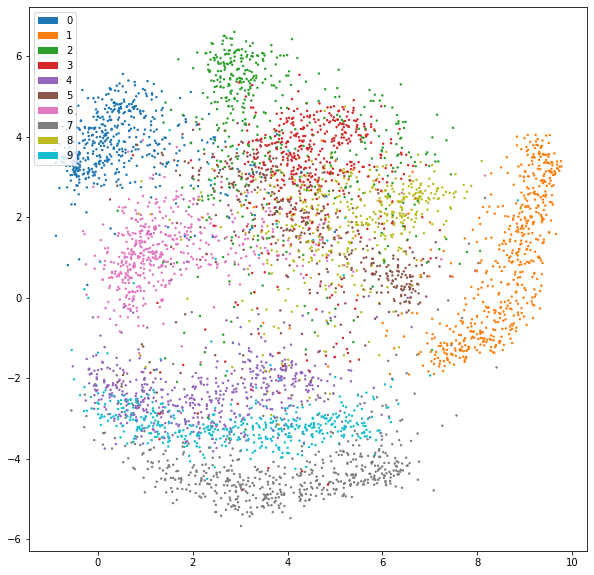

In [129]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:5000]]
#colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(bar[:,0],bar[:,1],c=colors, s=2)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [107]:
from umap import UMAP

In [111]:
embu = UMAP(n_neighbors=50, min_dist=0.1).fit_transform(testdata[:5000])

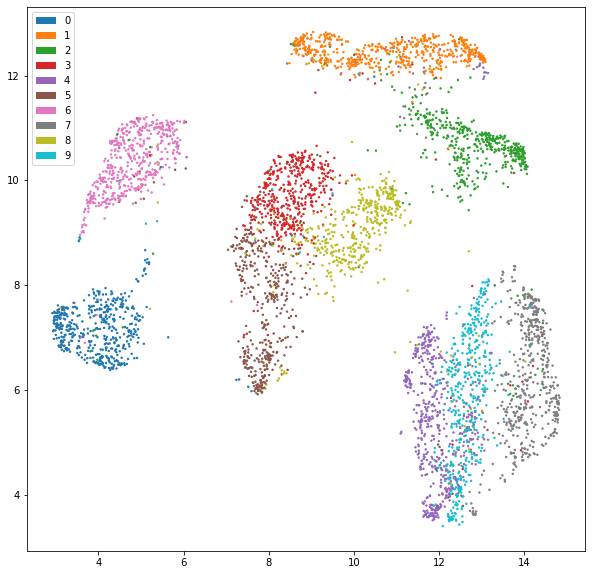

In [112]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:5000]]
#colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(embu[:,0],embu[:,1],c=colors, s=2)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [9]:
baz = ParametricUMAP(n_neighbors=50, min_dist=0.1).fit_transform(testdata[:5000])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
707/707 [==============================] - 12s 16ms/step - loss: 0.2908
Epoch 2/10
707/707 [==============================] - 12s 16ms/step - loss: 0.2538
Epoch 3/10
707/707 [==============================] - 12s 16ms/step - loss: 0.2457
Epoch 4/10
707/707 [==============================] - 12s 17ms/step - loss: 0.2422
Epoch 5/10
707/707 [==============================] - 12s 17ms/step - loss: 0.2401
Epoch 6/10
707/707 [==============================] - 12s 17ms/step - loss: 0.2392
Epoch 7/10
707/707 [==============================] - 12s 17ms/step - loss: 0.2376
Epoch 8/10
707/707 [==============================] - 12s 17ms/step - loss: 0.2363
Epoch 9/10
707/707 [==============================] - 12s 17ms/step - loss: 0.2359
Epoch 10/10
707/707 [==============================] - 12s 17ms/step - loss: 0.2360


In [10]:
baz

array([[ 1.5819894, -1.2768226],
       [ 2.3528051, -4.8923135],
       [-4.2374554, -1.1382585],
       ...,
       [ 1.3257469,  1.1968074],
       [ 0.7936261,  4.2614846],
       [ 1.4928279,  2.2788024]], dtype=float32)

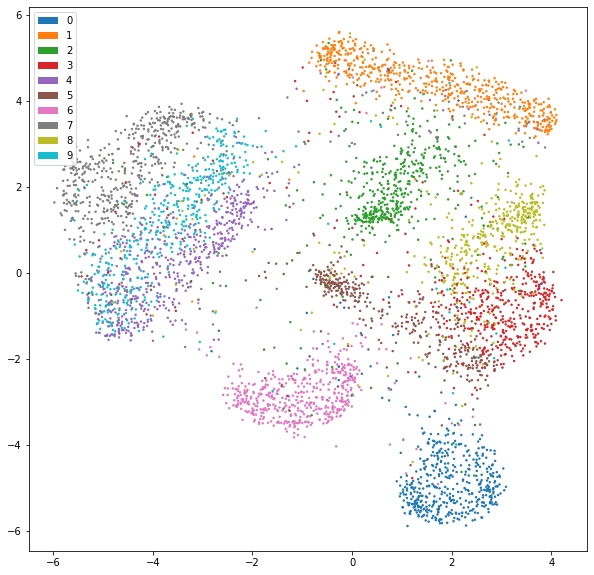

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:5000]]
#colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(baz[:,0],baz[:,1],c=colors, s=2)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [14]:
from umap.spectral import spectral_layout

In [36]:
spec = spectral_layout(testdata[:5000], p_precalc, 2, 42)

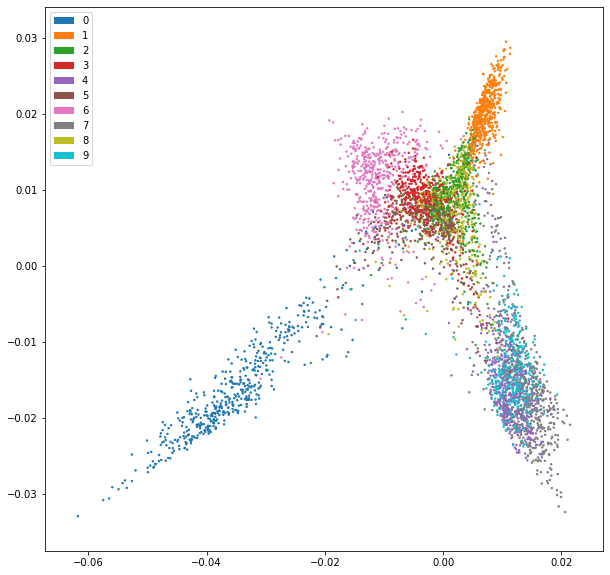

In [37]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:5000]]
#colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(spec[:,0],spec[:,1],c=colors, s=2)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [52]:
indices = p_precalc.nonzero()
probs = p_precalc.data

In [65]:
umap_counts = (probs * 200).astype(np.int32)

In [67]:
dummysampler = torch.utils.data.WeightedRandomSampler(probs, int(umap_counts.sum()))

In [87]:
unique, my_counts = np.unique(torch.tensor(list(dummysampler)), return_counts=True)

In [90]:
my_true_counts = np.zeros(len(umap_counts), dtype=np.int32)
my_true_counts[unique] = my_counts

In [91]:
my_true_counts

array([15,  9, 11, ..., 30, 28,  3])

In [92]:
umap_counts

array([14,  9, 11, ..., 41, 29,  5])

In [108]:
diff = umap_counts - my_true_counts

In [121]:
probs[np.where(np.abs(diff) > 30)].mean()

0.9106858948549096

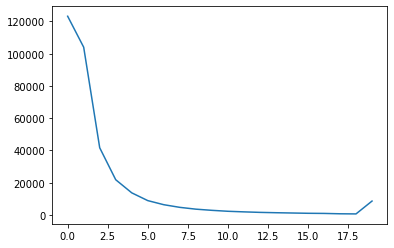

In [125]:
heights, bins = np.histogram(probs, bins=20)
plt.plot(heights)

In [124]:
heights

array([123256, 104050,  41686,  21858,  13732,   8914,   6372,   4730,
         3610,   2884,   2298,   1930,   1614,   1404,   1226,   1048,
          966,    744,    660,   8638], dtype=int64)